# Depth Metrics

This repository/notebook aims to implement the affine invariant protocol for relative monocular depth estimation models

- Step 1: Load the data.

- Step 2: Pre-process: Transform into disparity, apply masks, deal with zero division.

- Step 3: Align the prediction with groundtruth with least squares algorithm

- Step 4: Calculate the Metrics (AbsRel, delta, RMSE)

- Step 5: Output the results in pandas dataframe and figures.  

### Coisas pra fazer:
1) **Métricas**: implementar o código para outras métricas (delta123, RMSE) 
  
2) **Loop de teste**: fazer rodar para todas as imagens do dataset   

3) **Saída**: salvar em dataframe  

In [14]:
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from utils import get_sorted_files, show_rgbd, show_pred_gt, normal, depth_infos, abs_rel_error, cap_values, plot_histogram, normalize_depth, depth_report, generate_flat_array, align_depth

# Affine-Invariant Alignment

## 1. Load data

In [15]:
diode_path = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/"
diode_indoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/"
diode_outdoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/outdoor/"
diode_indoor_preds = "/home/gustavo/workstation/depth_estimation/data/outputs/DIODE-Anythingv2/npy/indoors/"

filenames_img = get_sorted_files(diode_indoor, ".png")
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_preds_indoor = get_sorted_files(diode_indoor_preds, ".npy")


In [16]:
index = 15
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.load(filenames_depth[index])
rgb = np.array(Image.open(filenames_img[index]))
H,W = groundtruth.shape[0], groundtruth.shape[1]
mask = np.load(filenames_mask[index])
mask = mask.reshape((H, W, 1))
mask1 = mask.reshape((H,W))

## 2. Pre Processing

In [17]:
groundtruth_capped_upper = cap_values(groundtruth, 0, 99)
groundtruth_masked = groundtruth*mask
groundtruth_masked_OG = groundtruth_masked.copy() # copia do GT masked original
mask_of_zeroes = (groundtruth_masked == 0) # mascara booleana para gerar indices onde o GT é zero
groundtruth_masked[mask_of_zeroes] = np.inf # substituição dos valores zero por np.inf
disparity_gt_masked = 1/groundtruth_masked

Visualization of the data 

- a) RGB Image
- b) Prediction from model in UINT8
- c) Groundtruth depth in UINT8
- d) Histogram from depth groundtruth

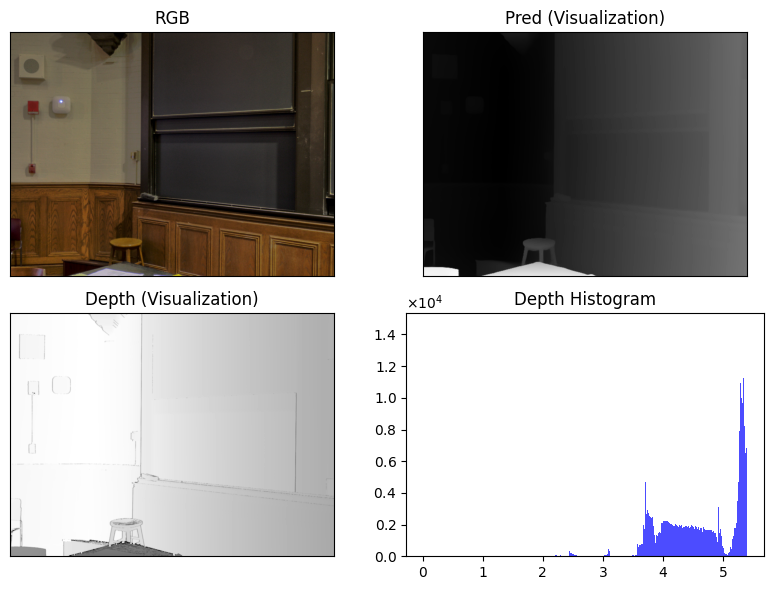

---- Depth Report ----

how many uniques: 655396
Max: 5.403973579406738
Min: 0.0
shape: (768, 1024, 1)
Dtype: float32
---- Depth Report ----

how many uniques: 769716
Max: 583.9976196289062
Min: 35.92858123779297
shape: (768, 1024)
Dtype: float32


In [18]:
depth_report(rgb, groundtruth_capped_upper, pred_diode, cap=False, uint=False)

## 3. Alignment via least squares algorithm

In [19]:
depth_aligned_masked = align_depth(disparity_gt_masked, pred_diode, mask1, return_depth=True, mask_output=True)

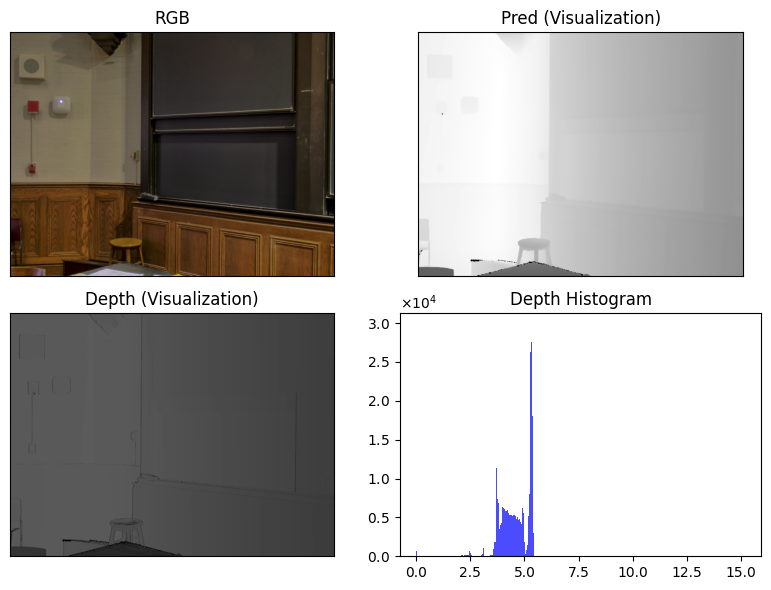

---- Depth Report ----

how many uniques: 661551
Max: 15.191486358642578
Min: 0.0
shape: (768, 1024, 1)
Dtype: float32
---- Depth Report ----

how many uniques: 769062
Max: 5.92936730806421
Min: 0.0
shape: (768, 1024)
Dtype: float64


In [20]:
depth_report(rgb, groundtruth_masked_OG ,depth_aligned_masked, cap=False, uint=False)

Histogram of the groundtruth and depth aligned

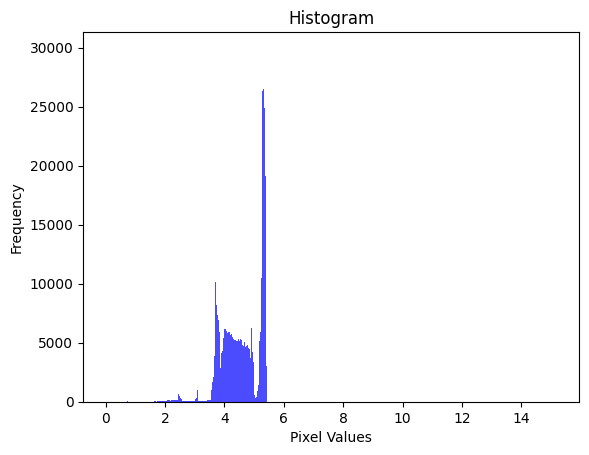

In [21]:
plot_histogram(groundtruth_masked_OG)

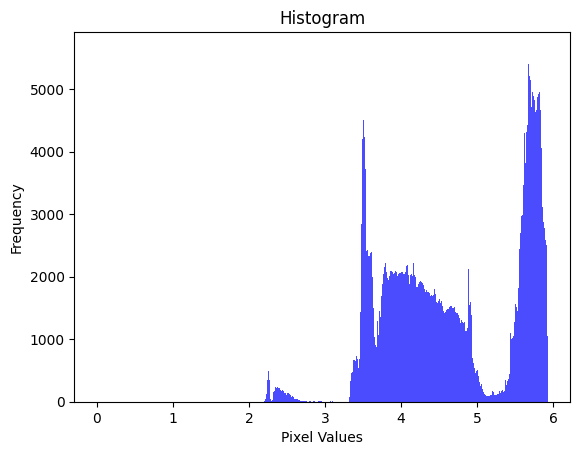

In [22]:
plot_histogram(depth_aligned_masked)

Visualization of a column of the groundtruth, and from the prediction. Then, align them both.

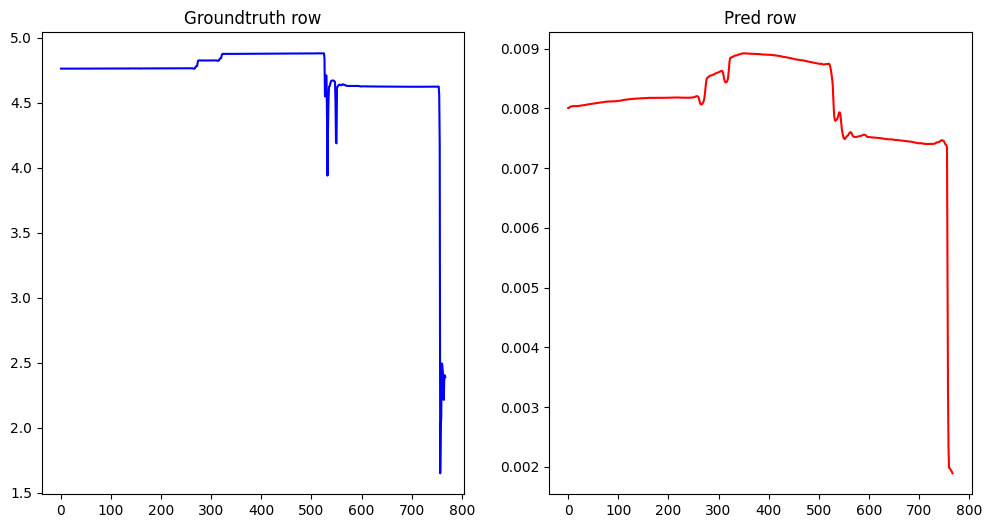

In [23]:
row_index = round(W*(1/2))
row_index = 500
pred_depth = (1/pred_diode)*mask1
GT_row = groundtruth_masked_OG[:, row_index]
pred_row = pred_depth[:, row_index]
pred_aligned_row = depth_aligned_masked[:, row_index]


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot( GT_row, 'b')
ax[0].set_title("Groundtruth row")
ax[1].plot(pred_row, 'r')
ax[1].set_title("Pred row")
plt.show()

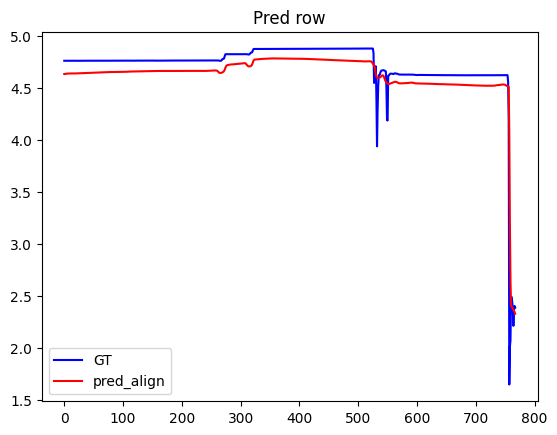

In [24]:
fig, ax = plt.subplots()
ax.plot(GT_row, 'b',label="GT")
ax.plot(pred_aligned_row, 'r', label="pred_align")
ax.set_title("Pred row")
ax.legend()
plt.show()

## 4. Calculate Metrics

In [29]:
abs_rel_error(depth_aligned_masked, groundtruth_masked_OG)

dtype('float64')

In [26]:
def calculate_delta(pred, gt, mask, threshold=1.25):
    err = np.zeros_like(pred, dtype=np.float64)

    err[mask == 1] = np.maximum(
        pred[mask==1] / gt[mask==1],
        gt[mask==1] / pred [mask==1],
    )

    err[mask == 1] = (err[mask == 1] > threshold)

    


In [36]:
def delta_depth_accuracy_with_mask(pred, gt, mask, threshold=1.25):
    """
    Calculates the delta depth accuracy for depth estimation with a mask.

    The delta accuracy measures the proportion of masked pixels where the ratio 
    between the predicted depth and the ground truth depth is within a certain threshold.

    Parameters:
    -----------
    pred : numpy.ndarray
        The predicted depth image array.
    
    gt : numpy.ndarray
        The ground truth depth image array.
    
    mask : numpy.ndarray
        A binary mask array where pixels with a value of 1 are considered in the calculation 
        and pixels with a value of 0 are ignored.
    
    threshold : float, optional
        The threshold for delta accuracy. For example, a threshold of 1.25 is commonly used as 
        delta_1. Default is 1.25.

    Returns:
    --------
    float
        The delta depth accuracy for the masked pixels, which is the proportion of masked pixels 
        where the ratio between the predicted and ground truth depth is within the given threshold.
    """
    #assert pred.shape == gt.shape == mask.shape, "Predicted, ground truth depth maps, and mask must have the same shape."
    pred = np.squeeze(pred)
    gt = np.squeeze(gt)
    mask = np.squeeze(mask)
    # Calculate the ratio between predicted and ground truth depths
    ratio = np.maximum(pred / gt, gt / pred)
    
    # Apply the mask
    masked_ratio = ratio[mask == 1]
    
    # Calculate the proportion of masked pixels within the threshold
    delta_accuracy = np.mean(masked_ratio < threshold)
    
    return delta_accuracy

In [37]:
delta_depth_accuracy_with_mask(depth_aligned_masked, groundtruth_masked_OG, mask, threshold=1.25)

/tmp/ipykernel_1348900/1099604549.py:35: RuntimeWarning: invalid value encountered in divide
  ratio = np.maximum(pred / gt, gt / pred)


np.float64(0.9873167863592457)

## 5. Output the results